In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')

# Import Data

In [20]:
data_train =pd.read_csv('train.csv')
data_test_a = pd.read_csv('testA.csv')

#  Feature Preprocessing

Find numerical features and category features

In [21]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
label = 'isDefault'
numerical_fea.remove(label)

## Handling missing values

In [22]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n3                  

Fill numeric features by average

In [23]:
data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
data_test_a[numerical_fea] = data_test_a[numerical_fea].fillna(data_train[numerical_fea].median())

Fill categorical features by majority

In [24]:
data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode())
data_test_a[category_fea] = data_test_a[category_fea].fillna(data_train[category_fea].mode())

##  Data type conversion

In [25]:
for data in [data_train, data_test_a]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [26]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
for data in [data_train, data_test_a]:
    data['employmentLength'].replace('10+ years', '10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

data['employmentLength'].value_counts(dropna=False).sort_index()

employmentLength
0.0     15989
1.0     13182
2.0     18207
3.0     16011
4.0     11833
5.0     12543
6.0      9328
7.0      8823
8.0      8976
9.0      7594
10.0    65772
NaN     11742
Name: count, dtype: int64

In [27]:
for data in [data_train, data_test_a]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

## Objective data

In [33]:
cate_features = ['grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', \
                 'applicationType', 'initialListStatus', 'title', 'policyCode']
for f in cate_features:
    print(f, 'number of features:', data[f].nunique())

grade number of features: 7
subGrade number of features: 35
employmentTitle number of features: 79282
homeOwnership number of features: 6
verificationStatus number of features: 3
purpose number of features: 14
postCode number of features: 889
regionCode number of features: 51
applicationType number of features: 2
initialListStatus number of features: 2
title number of features: 12058
policyCode number of features: 1


In [34]:
for data in [data_train, data_test_a]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [35]:
for data in [data_train, data_test_a]:
    data = pd.get_dummies(data, columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)

## Outlier treatment

In [41]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:True if x > upper_rule or x < lower_rule else False)
    return data

In [43]:
data_train = data_train.copy()
for fea in numerical_fea:
    data_train = find_outliers_by_3segama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print(data_train.groupby(fea+'_outliers')['isDefault'].value_counts())
    print('*'*10)

id_outliers
False    800000
Name: count, dtype: int64
id_outliers  isDefault
False        0            640390
             1            159610
Name: count, dtype: int64
**********
loanAmnt_outliers
False    800000
Name: count, dtype: int64
loanAmnt_outliers  isDefault
False              0            640390
                   1            159610
Name: count, dtype: int64
**********
term_outliers
False    800000
Name: count, dtype: int64
term_outliers  isDefault
False          0            640390
               1            159610
Name: count, dtype: int64
**********
interestRate_outliers
False    794259
True       5741
Name: count, dtype: int64
interestRate_outliers  isDefault
False                  0            637565
                       1            156694
True                   1              2916
                       0              2825
Name: count, dtype: int64
**********
installment_outliers
False    792046
True       7954
Name: count, dtype: int64
installment_outliers  isDef

In [44]:
for fea in numerical_fea:
    data_train=data_train[~data_train[fea+'_outliers']]
    data_train=data_train.reset_index(drop=True)

In [45]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612742 entries, 0 to 612741
Data columns (total 89 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id                           612742 non-null  int64         
 1   loanAmnt                     612742 non-null  float64       
 2   term                         612742 non-null  int64         
 3   interestRate                 612742 non-null  float64       
 4   installment                  612742 non-null  float64       
 5   grade                        612742 non-null  int64         
 6   subGrade                     612742 non-null  object        
 7   employmentTitle              612742 non-null  float64       
 8   employmentLength             577657 non-null  float64       
 9   homeOwnership                612742 non-null  int64         
 10  annualIncome                 612742 non-null  float64       
 11  verificationStatus        

# Feature Creation

In [46]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [48]:
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

#  Feature Encoding

In [50]:
for col in tqdm(['employmentTitle', 'postCode', 'title','subGrade']):
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test_a[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))
print('Label Encoding finished')

100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

Label Encoding finished


# Feature Selection

In [51]:
for data in [data_train, data_test_a]:
    data.drop(['issueDate','id'], axis=1,inplace=True)

In [53]:
x_train = data_train.drop(['isDefault'], axis=1)
#计算协方差
data_corr = x_train.corrwith(data_train.isDefault) #计算相关性
result = pd.DataFrame(columns=['features', 'corr'])
result['features'] = data_corr.index
result['corr'] = data_corr.values

In [60]:
numerical_fea=['loanAmnt',
 'term',
 'interestRate',
 'installment',
 'employmentTitle',
 'homeOwnership',
 'annualIncome',
 'verificationStatus',
 'isDefault',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'initialListStatus',
 'applicationType',
 'title',
 'policyCode',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'n13',
 'n14']

<Axes: title={'center': 'Correlation of Numeric Features with Price'}>

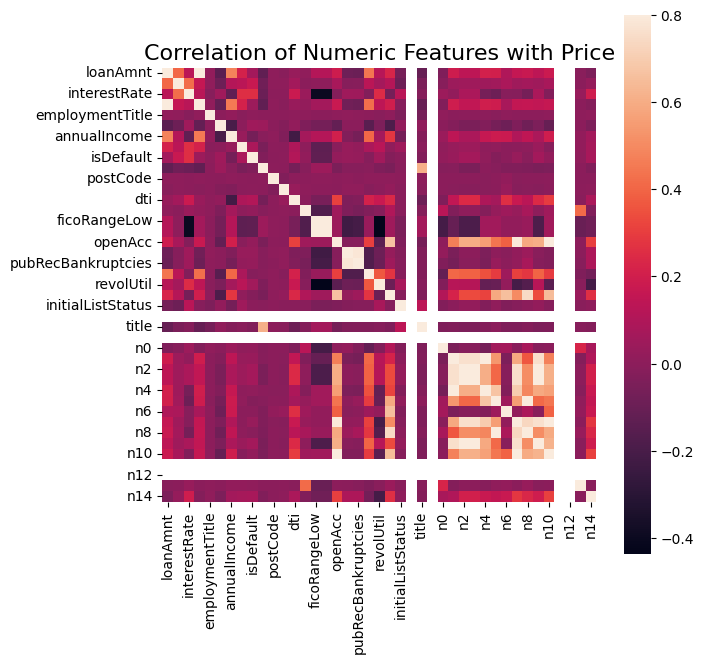

In [61]:
# 当然也可以直接看图
data_numeric = data_train[numerical_fea]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)